In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import copy
from matplotlib import colors
from sklearn import tree
#import skfda
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import timeshap
from timeshap.explainer import event_level, feature_level

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import scipy.signal
#import cartopy.crs as ccrs
#import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
#import torchvision
#import torch.nn.functional as F
#from torch.utils.data import TensorDataset, DataLoader, random_split
#import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *
import sys
sys.path.append("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\optimisation_experiments")
from optimise_GDD_fctns import *
from WaveNet_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
#from suntimes import SunTimes  
from pyJoules.energy_meter import measure_energy

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
C:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\optimisation_experiments\optimise_GDD_fctns.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dw

In [6]:
def get_comparison_frame(savename, TS_model, val_dl, 
                         CNN = True, MMD = False, 
                         DTF = False, bce = True, 
                         obs_method=False, n_channels = 5):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_details = []
    for xb, yb in val_dl:
        with torch.no_grad():
            if CNN:
                if MMD:
                    list_logs.append(TS_model(xb)[0])
                else:
                    list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
        list_details.append(xb[:, -4:, 0])

    logs = torch.squeeze(torch.cat(list_logs))
    observed = torch.cat(list_observed)
    details = torch.cat(list_details).numpy()
    #print(logs.shape, torch.cat(list_logs, dim=0).shape)
    if not(DTF):
        if bce:
            fitted = torch.round(logs)
        else:
            fitted = torch.argmax(logs, dim=2)
    if DTF:
        logs = torch.round(logs)
        observed_days = mindex_at_0(observed)
        observed_days = observed[:, 0]
        observed_days = 90 + 100 - observed[:, 90]
        if obs_method:
            fitted_days = observed_days + logs[range(0, logs.shape[0]), observed_days.int()]
        else:
            fitted_days = mindex_at_0(logs)
            fitted_days = 90 + 100 - logs[:, 90]
            #fitted_days = logs[:, 90]
        #print(torch.sum(fitted_days < 30), ' fits too small')
    else:
        if len(fitted.shape) == 1:
            L = fitted.shape[0]
            fitted_days = L - fitted.sum()
            observed_days = L - observed.sum()
        else:
            L = fitted.shape[1]
            fitted_days = L - fitted.sum(dim=1)
            observed_days = L - observed.sum(dim=1)
    
    #comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    if len(fitted.shape) > 1:
        comparison_frame = pd.DataFrame({'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    else:
        comparison_frame = pd.DataFrame({'fitted': [fitted_days.numpy().squeeze()], 'observed': [observed_days.numpy().squeeze()]})
    comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']
    comparison_frame[['vargroup', 'Management', 'year', 'Stations_id']] = details
    comparison_frame['vargroup'] = pd.Categorical.from_codes(comparison_frame['vargroup'].values.astype(int), ['EIHY', 'EPOP', 'ILHY', 'ILPO'])
    comparison_frame['Management'] = pd.Categorical.from_codes(comparison_frame['Management'].values.astype(int), ['Drought', 'Low N', 'Low pH', 'Maize Streak Virus', 'Optimal'])
    return comparison_frame

In [ ]:
def K_fold_transfer(k_folds, ds, model_class, 
                    savename, epochs, bs, model_args, 
                    transfer_method = 'KG', #could be any of: 'KG', 'last_layer', 'first_layer', 'last_wave', 'first_wave
                    lr = 0.01, savename_prefix = 'KFold', 
                    freeze_params = False, loss = 'NLL', 
                    CNN=False, bce=False, custom_loss = None, 
                    MMD = False, DTF = False, obs_method = False, verbose=False,
                    index_cols = ['Stations_id', 'year', 'Management', 'vargroup']):
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    # Loop through each fold
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_values = []
    R2s = []
    Biases = []
    Variances = []
    obsvars = []

    RMSEs = []
    SSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    lengths = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    statyear = ds[index_cols].drop_duplicates()
    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=index_cols, how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=index_cols, how = 'inner')
        lengths.append(len(test))
        #print(f"Fold {fold + 1}")
        X_tensor_train, y_tensor_train = ML_tensor_from_ds(train)
        X_tensor_test, y_tensor_test = ML_tensor_from_ds(test)
        print(len(ds), X_tensor_test.shape, X_tensor_train.shape)
        train_ds, ___ = train_test_ds_from_tensors(X_tensor_train, y_tensor_train, train_proportion=1)
        val_ds, ___ = train_test_ds_from_tensors(X_tensor_test, y_tensor_test, train_proportion=1)
        # Define the data loaders for the current fold
        train_dl = DataLoader(
            dataset=train_ds,
            batch_size=bs,
        )
        val_dl = DataLoader(
            dataset=val_ds,
            batch_size=bs,
        )
        #lenval = 0
        #lentr = 0
        #for xb, yb in train_dl:
        #    lentr += xb.shape[0]
        #for xb, yb in val_dl:
        #    lenval += xb.shape[0]
        #print(lentr, lenval)
        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        #for param in model.fc.parameters():
        #    param.requires_grad = False
        #for param in model.lstm.parameters():
        #    param.requires_grad = False
        ft_params = get_ft_params(model, transfer_method)
        #print(ft_params)
        for param in model.parameters():
            param.requires_grad = False
        for param in ft_params:
            param.requires_grad = True
        
        optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay = 0.01)
        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False
        #for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
        #    print(param.requires_grad, param.shape)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, 
                                train_dl, val_dl, save_name = savename_prefix + str(fold + 1), 
                                CNN=CNN, bce=bce, plot_opt=False, verbose=verbose)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        # Now convert to days and get R^2 to compare to other models
        comparison_frame = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, val_dl, CNN=CNN, MMD = MMD, DTF=DTF, bce=bce, obs_method=obs_method)
        train_frame = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, train_dl, CNN=CNN, MMD = MMD, DTF=DTF, bce=bce, obs_method=obs_method)
        #comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']
        bias_model = 0#comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        SSE = np.sum((comparison_frame['Error'] - bias_model)**2)
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        SSEs.append(SSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        variance_observed = comparison_frame['observed'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)
        obsvars.append(variance_observed)
        if fold == 0:
            comparison_frame_full = comparison_frame
        else:
            comparison_frame_full = pd.concat((comparison_frame, comparison_frame_full))
        #fig, ax = plt.subplots()
        #sns.regplot(x='fitted', y='observed', data = comparison_frame,
        #            scatter_kws={'alpha':0.5, 's':4},  x_bins=10)
        #maxval = max(comparison_frame['fitted'].max(), comparison_frame['observed'].max())
        #minval = min(comparison_frame['fitted'].min(), comparison_frame['observed'].min())
        #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')

    return comparison_frame_full, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars


In [8]:
def K_fold_transfer_regions(ds_dict, transfer_method = 'KG', GDD_init = None, 
                            index_cols = ['Stations_id', 'year', 'Management', 'vargroup']):
    #if transfer_method == 'last_layer':
    #    lr = 0.01
    #    epochs = 500
    #else:
        #lr = 0.05
    lr = 0.001
    epochs=500
        #epochs = 500
    save_name = 'CCNN_KG_DE_pre_2022_for_TL3'
    #save_name = 'CCNN_KG_DE_pre_2022_for_TL2'
    save_name = 'CCNN_KG_DE_pre_2022_for_TL_huge'
    #save_name = 'CCNN_KG_DE_pre_2022_for_TL_small'#_huge'
    bs = 500
    n_channels = 5#5#5
    input_dim = n_channels # Example: 100-dimensional word embeddings
    hidden_dim = 32#4#32#8#4#8
    normalise_at_end = False#True
    num_layers = 3
    output_dim = 1 
    KG = True
    MMD = False
    regression = False
    KG_vpd = False
    CNN = True
    bce = True
    model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
    # initialise lists for storing
    SSE_all_reg = []
    length_all_reg = []
    obsvars_all_reg = []
    regs = []
    comparison_frames = []
    for region in ds_dict.keys():
        #get data for specific region
        ds = ds_dict[region]
        if len(ds) < 10:
            continue
        regs.append(region)
        #convert to pytorch format
        #X_tensor, y_tensor = ML_tensor_from_ds(ds)
        #train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
        #run K-fold cross validation
        criterion = problist_square_loss()
        
        if transfer_method == 'in domain':
            if GDD_init is None:
                lr = 0.05
                epochs = 2000
                hidden_dim = 2
                num_layers = 1
                model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
            else:
                n_channels = 5#5
                input_dim = n_channels
                lr = 0.0001
                epochs = 100
            comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_crossval(5, ds, Causal_CNN_Classifier_KG, 
                                                                                                                    epochs, bs, model_args, 
                                                                                                                    lr = lr, n_channels=n_channels,
                                                                                                                    loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                                    custom_loss=problist_square_loss, DTF = False, verbose=True,
                                                                                                                    GDD_init=GDD_init, index_cols=index_cols)
        else:
            comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, ds, Causal_CNN_Classifier_KG, 
                                                                                                                    save_name, epochs, bs, model_args, 
                                                                                                                    transfer_method=transfer_method, lr = lr, 
                                                                                                                    loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                                    custom_loss=criterion, DTF = False,
                                                                                                                    index_cols=index_cols)
        comparison_frames.append(comparison_frame)
        print(region, R2s)
        #Store sum of squared errors, variance of obs and length of folds for evaluation
        SSE_all_reg.append(SSEs)
        length_all_reg.append(lengths)
        obsvars_all_reg.append(obsvars)
    results_dict = {'SSEs': SSE_all_reg,
                    'observed variances': obsvars_all_reg,
                    'fold lengths': length_all_reg,
                    'regions': regs,
                    'comparison_frames': comparison_frames}
    return results_dict

In [9]:
def K_fold_crossval(k_folds, input_dataset, model_class, 
                    epochs, bs, model_args, savename_prefix = 'KFold', 
                    freeze_params = False, loss = 'NLL', 
                    CNN=False, bce=False, lr = 0.01, 
                    MMD=False, n_channels = 4, DTF = False, 
                    obs_method = False, custom_loss = None,
                    year_split = False, year_folds = None,
                    GDD_init = None, verbose = False,
                    index_cols = ['Stations_id', 'year', 'Management', 'vargroup']):
    #['year', 'Stations_id']
    ## LSTM_args: input_dim, hidden_dim, num_layers, output_dim
    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    # Loop through each fold
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    loss_values = []
    R2s = []
    Biases = []
    Variances = []
    obsvars = []

    RMSEs = []
    SSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    lengths = []
    if year_split:
        splitter = year_folds
    else:
        statyear = input_dataset[index_cols].drop_duplicates()
        splitter = kf.split(statyear)
    for fold, traintest_idx in enumerate(splitter):
        print(f"Fold {fold + 1}")
        if year_split:
            X_tensor, y_tensor = train_ds
            train_dl, val_dl = train_test_dl_by_year(X_tensor, y_tensor, test_years = traintest_idx, year_column = -2, bs = bs, n_channels = 8)
        # Define the data loaders for the current fold
        else:
            train_idx, test_idx = traintest_idx
            train_statyear = statyear.iloc[train_idx]
            test_statyear = statyear.iloc[test_idx]
            train = input_dataset.merge(train_statyear, on=index_cols, how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
            test = input_dataset.merge(test_statyear, on=index_cols, how = 'inner')
            lengths.append(len(test))
            X_tensor_train, y_tensor_train = ML_tensor_from_ds(train)
            X_tensor_test, y_tensor_test = ML_tensor_from_ds(test)
            print(len(input_dataset), X_tensor_test.shape, X_tensor_train.shape)
            train_ds, ___ = train_test_ds_from_tensors(X_tensor_train, y_tensor_train, train_proportion=1)
            val_ds, ___ = train_test_ds_from_tensors(X_tensor_test, y_tensor_test, train_proportion=1)
            train_dl = DataLoader(
                dataset=train_ds,
                batch_size=bs,
            )
            val_dl = DataLoader(
                dataset=val_ds,
                batch_size=bs,
            )
        #print(len(train_dl.dataset), len(val_dl.dataset))
        # Initialize the model and optimizer
        model = model_class(*model_args).to(device)
        if GDD_init is not None:
            if GDD_init == 'calculate':
                x1s = [np.array([0.5, 8, 23, 39])]
                fm = local_opt(x1s, train, test,
                            lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                            great_threshold = 13, response_type = 'Wang',
                            phase_list = ['beginning of flowering'],
                            method='Nelder-Mead',
                            thresholds = [20], growing_period_length=170,
                            test_size = 0.02, maxiter=200)
                GDD_params = fm[0][0]
                print(GDD_params)
                model = initialise_as_GDD(model, *GDD_params, n_channels=5)
            else:
                GDD_params = GDD_init[fold]#[0.31621224, 7.37066436, 22.88481424, 39.40562477]
                print(GDD_params)
                model = initialise_as_GDD(model, *GDD_params, n_channels=5)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        if loss == 'NLL':
            criterion = nn.NLLLoss()
        elif loss == 'BCE':
            criterion = nn.BCELoss()
        elif loss == 'MSE':
            criterion = custom_loss()
        # Train the model on the current fold
        if freeze_params:
            for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
                param.requires_grad = False
        #for xb, yb in train_dl:
        #    print(xb.shape, yb.shape)
        model_loss = fit_for_kf(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = savename_prefix + str(fold + 1), CNN=CNN, bce=bce, verbose=verbose)
        loss_values.append(model_loss)

        #Now look at stats for model:
        model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
        model_path = os.path.join(model_dir, savename_prefix + str(fold + 1) + ".pt")
        checkpoint = torch.load(model_path, weights_only=True)
        TS_model = model_class(*model_args).to(device)
        TS_model.load_state_dict(checkpoint['model_state_dict'])

        comparison_frame = get_comparison_frame(savename_prefix + str(fold + 1), TS_model, val_dl, bce=bce, CNN=CNN, MMD=MMD, n_channels = n_channels, DTF = DTF, obs_method = obs_method)
        comparison_frame['Error'] = comparison_frame['observed'] - comparison_frame['fitted']
        bias_model = 0#comparison_frame['Error'].mean()
        RMSE = np.sqrt(np.mean((comparison_frame['Error'] - bias_model)**2))
        SSE = np.sum((comparison_frame['Error'] - bias_model)**2)
        STD = comparison_frame['fitted'].std() 
        Corr = comparison_frame['observed'].corr(comparison_frame['fitted'])

        RMSEs.append(RMSE)
        SSEs.append(SSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_frame['Error'].min())
        LQs.append(comparison_frame['Error'].quantile(0.25))
        Medians.append(comparison_frame['Error'].median())
        UQs.append(comparison_frame['Error'].quantile(0.75))
        Maxs.append(comparison_frame['Error'].max())

        rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
        bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
        variance_modelled = comparison_frame[f'fitted'].var()
        variance_observed = comparison_frame['observed'].var()
        
        R2s.append(rsquared)
        Biases.append(bias)
        Variances.append(variance_modelled)
        obsvars.append(variance_observed)

        if fold == 0:
            comparison_frame_full = comparison_frame
        else:
            comparison_frame_full = pd.concat((comparison_frame, comparison_frame_full))

    return comparison_frame_full, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars

In [19]:
skip = 1
numsteps = int(163 // skip)
#ds_inputs_DE1 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_full.csv')
#ds_inputs_DE1[[f't2max at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE1[[f't2min at day {skip*n}' for n in range(numsteps)]] += -273.15
#ds_inputs_DE2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_90s.csv')

#ds_inputs_DE = pd.concat([ds_inputs_DE1, ds_inputs_DE2], axis = 0)
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_full.csv')
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='all')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 140]
ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] > 40]
new_series = []
ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2max at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values
ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]] = ds_inputs_DE.loc[:, [f't2m at day {skip*n}' for n in range(numsteps)]].values - ds_inputs_DE.loc[:, [f't2min at day {skip*n}' for n in range(numsteps)]].values
for variable_name in ['t2m', 't2max', 't2min', 'photoperiod', 'vpd']: #, 'ssrd', 'tp'
    data = ds_inputs_DE[[f'{variable_name} at day {skip*n}' for n in range(numsteps)]].values
    #if variable_name != 't2m' and variable_name != 'photoperiod':
    #    scaler = StandardScaler()
    #    scaler.fit(data)
    #    data = scaler.transform(data)
    new_variable_series = torch.Tensor(data)
    new_series.append(new_variable_series)

day_series_DE = torch.Tensor([[(skip*n)/10 for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'].values for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((*new_series, day_series_DE, year_series_DE, id_series_DE)), 0, 1)
ds_inputs_DE.loc[:, [f'DTF at day {n}' for n in range(193)]] = np.tile(ds_inputs_DE['observed time to beginning of flowering'].values, (193, 1)).T - np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

#NDVI_labels_DE = torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype(int).values).unsqueeze(1)
#NDVI_labels_DE = 100 - torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)
#NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'DTF at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

27153
27153


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_23764\1009952979.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_34s6o8i12c\croot\libtorch_1751464457133\work\torch\csrc\utils\tensor_new.cpp:257.)
  year_series_DE = torch.Tensor([ds_inputs_DE['year'].values for count in range(numsteps)]).T


In [10]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008_with_varieties_fixed_vpd.csv')
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 105]
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Referenzjahr': 'year'})
ds_sites_AEZ2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\African_data\\Lobell2011\\EIL_site_latlon_with_AEZ_filled.csv')
ds_inputs_SSA = ds_inputs_SSA.merge(ds_sites_AEZ2.rename(columns = {'LocationID': 'Stations_id'})[['Stations_id', 'AEZ2']], on='Stations_id', how='left')
ds_inputs_SSA['AEZ'] = ds_inputs_SSA['AEZ2']
ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['lat'] > -25]
#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['Management'] == 'Optimal']

In [11]:
ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].groupby(['Stations_id', 'year', 'Management']).first().reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
ds_SSA_early = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'EPOP')|(ds_inputs_SSA['vargroup'] == 'EIHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])

#ds_SSA_early = ds_SSA_early.loc[(ds_SSA_early['Management'] == 'Optimal')|(ds_SSA_early['Management'] == 'Low pH')|(ds_SSA_early['Management'] == 'Low N')].groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
#ds_SSA_early = ds_SSA_early.groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
early_ds_dict = split_ds_by_AEZ5(ds_SSA_early)


num semiarid low: 120 
num arid high: 59 
num humid low: 26 
num subhumid low: 67 
num subhumid high: 45


In [12]:
AEZ_dict = {1: 'Tropics, lowland; semi-arid',
            2: 'Tropics, lowland; sub-humid',
            3: 'Tropics, lowland; humid',
            4: 'Tropics, highland; semi-arid',
            5: 'Tropics, highland; sub-humid',
            10: 'Sub-tropics, moderately cool; semi-arid',
            11: 'Sub-tropics, moderately cool; sub-humid',
            14: 'Sub-tropics, cool; sub-humid',
            26: 'Land with severe soil/terrain limitations',
            27: 'Land with ample irrigated soils',
            29: 'Desert/Arid climate',
            32: 'Dominantly built-up land',
            33: 'Dominantly water'
            }

In [13]:
ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].groupby(['Stations_id', 'year', 'Management']).first().reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
ds_SSA_late = ds_inputs_SSA.loc[(ds_inputs_SSA['vargroup'] == 'ILPO')|(ds_inputs_SSA['vargroup'] == 'ILHY')].reset_index().drop(columns=['Unnamed: 0'])#, 'Unnamed: 0.1'])
#ds_SSA_late = ds_SSA_late.loc[(ds_SSA_late['Management'] == 'Optimal')|(ds_SSA_late['Management'] == 'Low pH')|(ds_SSA_late['Management'] == 'Low N')].groupby(['Stations_id', 'Referenzjahr']).first().reset_index()
late_ds_dict = split_ds_by_AEZ5(ds_SSA_late)


num semiarid low: 101 
num arid high: 50 
num humid low: 17 
num subhumid low: 68 
num subhumid high: 46


In [ ]:
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
results_combined_test_indomain_KG = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='in domain', GDD_init = 'calculate', index_cols = ['Stations_id'])
results_combined_test_indomain = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='in domain', GDD_init = None, index_cols = ['Stations_id'])

Fold 1
Optimization terminated successfully.
         Current function value: 9.183972
         Iterations: 57
         Function evaluations: 134
[ 0.5  8.  23.  39. ] [ 0.33260549  8.12068022 26.40273702 39.08301718] [ 0.16739451 -0.12068022 -3.40273702 -0.08301718]
RMSE at opt on test set:  9.288901331334207
R^2: 0.6186452861501859
[ 0.33260549  8.12068022 26.40273702 39.08301718]
0 49.537166595458984 50.00441360473633
10 44.22221374511719 42.782073974609375
20 41.355098724365234 38.4239387512207
30 40.17827606201172 37.183067321777344
40 39.13970184326172 36.97550964355469
50 38.18739318847656 37.0157585144043
60 37.35468673706055 37.3406982421875
70 36.56490707397461 37.420501708984375
80 35.85932922363281 37.56168746948242
90 35.217071533203125 37.60674285888672
Fold 2
Optimization terminated successfully.
         Current function value: 7.231126
         Iterations: 50
         Function evaluations: 132
[ 0.5  8.  23.  39. ] [ 0.34472656  8.20507812 26.73413086 39.07543945] [ 0.

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 5
0 8210.1826171875 10077.857421875
10 8210.1826171875 10077.857421875
20 8210.177734375 10077.84375
30 7202.57080078125 4338.63037109375
40 250.3339385986328 495.7191467285156
50 280.817626953125 27.35917091369629
60 167.58493041992188 38.185203552246094
70 132.2118682861328 43.61011505126953
80 112.38069152832031 123.69071197509766
90 85.861083984375 123.63321685791016
100 75.4197769165039 51.01487350463867
110 46.16376495361328 50.967132568359375
120 45.76470184326172 24.924484252929688
130 39.585784912109375 34.17892074584961
140 31.42579460144043 17.96084976196289
150 36.504146575927734 37.34416198730469
160 28.53987693786621 18.866865158081055
170 24.566781997680664 20.98904800415039
180 23.638341903686523 19.418521881103516
190 23.29221534729004 30.409984588623047
200 31.62330436706543 25.187519073486328
210 23.43389892578125 23.417123794555664
220 23.31203269958496 26.55681800842285
230 25.249055862426758 25.445016860961914
240 24.337766647338867 24.283233642578125
250 23.

In [29]:
results_combined_test_indomain_KG = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='in domain', GDD_init = 'calculate', index_cols = ['Stations_id'])

Fold 1
Optimization terminated successfully.
         Current function value: 9.183972
         Iterations: 57
         Function evaluations: 134
[ 0.5  8.  23.  39. ] [ 0.33260549  8.12068022 26.40273702 39.08301718] [ 0.16739451 -0.12068022 -3.40273702 -0.08301718]
RMSE at opt on test set:  9.288901331334207
R^2: 0.6186452861501859
[ 0.33260549  8.12068022 26.40273702 39.08301718]
0 49.53715896606445 50.00440979003906
10 44.22221755981445 42.7821159362793
20 41.35509490966797 38.42392349243164
30 40.17827606201172 37.18302536010742
40 39.139686584472656 36.975467681884766
50 38.187381744384766 37.01579666137695
60 37.35466766357422 37.340667724609375
70 36.56483840942383 37.42019271850586
80 35.8592643737793 37.56148910522461
90 35.217002868652344 37.60658645629883
Fold 2
Optimization terminated successfully.
         Current function value: 7.231126
         Iterations: 50
         Function evaluations: 132
[ 0.5  8.  23.  39. ] [ 0.34472656  8.20507812 26.73413086 39.07543945] [ 0.

In [14]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
no_regions_test_indomain = K_fold_transfer_regions(no_regions_dict, transfer_method='in domain', GDD_init = None, index_cols=['Stations_id', 'year'])#'calculate')
results_combined_test_indomain = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='in domain', GDD_init = None, index_cols=['Stations_id', 'year'])#'calculate')

Fold 1
351 torch.Size([76, 10, 163]) torch.Size([275, 10, 163])


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_18336\811103719.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_34s6o8i12c\croot\libtorch_1751464457133\work\torch\csrc\utils\tensor_new.cpp:257.)
  year_series = torch.Tensor([ds['year'].values for count in range(numsteps)]).T


0 9140.31640625 9417.5390625
50 784.7069091796875 927.7744750976562
100 74.59036254882812 107.43569946289062
150 68.34027099609375 72.06163787841797
200 63.40864944458008 63.54802322387695
250 145.7178192138672 91.26721954345703
300 42.510650634765625 39.72582244873047
350 36.90556716918945 40.96339797973633
400 81.38692474365234 85.21534729003906
450 237.8562469482422 208.5605010986328
500 43.09224319458008 37.36174392700195
550 37.219886779785156 42.59067916870117
600 34.50660705566406 42.416019439697266
650 34.38874053955078 32.64247512817383
700 33.4016227722168 44.09288787841797
750 32.43021774291992 33.5765495300293
800 33.49336624145508 45.98805236816406
850 30.48292350769043 35.08566665649414
900 32.23724365234375 44.70060348510742
950 30.37877082824707 34.782386779785156
1000 32.845977783203125 46.37657928466797
1050 30.321828842163086 34.89128494262695
1100 33.02019119262695 47.14966583251953
1150 30.62036895751953 34.74869918823242
1200 31.953529357910156 45.3063850402832
12

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fold 4
135 torch.Size([27, 10, 163]) torch.Size([108, 10, 163])
0 10408.47265625 9814.6298828125
50 1937.2596435546875 1513.5076904296875
100 50.54716491699219 94.58600616455078
150 33.86209487915039 83.9900894165039
200 25.916555404663086 55.93152618408203
250 24.423952102661133 51.27818298339844
300 22.13729476928711 29.410499572753906
350 20.81320571899414 28.63636589050293
400 19.450105667114258 28.275129318237305
450 18.04979705810547 28.18992805480957
500 17.16213607788086 25.33572006225586
550 15.746545791625977 25.498140335083008
600 14.475384712219238 24.61438751220703
650 14.073114395141602 26.779436111450195
700 13.890003204345703 27.435192108154297
750 14.025243759155273 30.030000686645508
800 13.537519454956055 28.097299575805664
850 13.140874862670898 25.60154151916504
900 12.783041954040527 22.527738571166992
950 12.60971450805664 21.0687255859375
1000 12.317656517028809 22.940784454345703
1050 11.919456481933594 31.482755661010742
1100 11.739082336425781 25.264421463012

In [15]:
for ind, score_dict in enumerate([results_combined_test_indomain]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, df_novar_full = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_full['region'] = 'all combined'
#df_noreg, df_noreg_pooled, ___ = make_df_from_score_dict(no_regions_test_indomain)
df_novar_pooled = pd.concat([df_novar_full, df_novar_pooled])
df_novar_pooled['Model'] = 'WaveNet in domain'
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_indomain2.csv')

In [16]:
df_noreg, df_noreg_pooled, ___ = make_df_from_score_dict(no_regions_test_indomain)
df_noreg_pooled['Variety'] = ['Early', 'Late']
df_noreg_pooled['Model'] = 'WaveNet in domain'
df_noreg_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_regions_pooled_score_indomain2.csv')

In [31]:
for ind, score_dict in enumerate([results_combined_test_indomain_KG]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar_KG, df_novar_pooled_KG, ____ = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar_KG['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled_KG['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])

In [13]:
for ind, score_dict in enumerate([results_combined_test_KG]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar_KG, df_novar_pooled_KG, ____ = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar_KG['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled_KG['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])

In [14]:
df_novar_pooled_KG

,R2 score,Variety,region
0,0.556489,combined,arid low
1,-0.918781,combined,arid high
2,0.298108,combined,humid low
3,-0.008322,combined,humid high


In [37]:
df_novar_pooled_KG

,R2 score,Variety,region
0,0.623565,combined,arid low
1,-0.732076,combined,arid high
2,0.172773,combined,humid low
3,-0.233432,combined,humid high


In [87]:
df_novar_pooled

,R2 score,Variety,region
0,0.668745,combined,arid low
1,0.076882,combined,arid high
2,0.405064,combined,humid low
3,0.100461,combined,humid high


In [83]:
df_novar_pooled

,R2 score,Variety,region
0,0.655052,combined,arid low
1,-0.088453,combined,arid high
2,0.368731,combined,humid low
3,0.113411,combined,humid high


In [88]:
df_noreg_pooled

,R2 score,Variety
0,0.537457,NA
1,0.502709,NA


In [84]:
df_noreg_pooled

,R2 score,Variety
0,0.572391,NA
1,0.448098,NA


In [ ]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
no_regions_test_indomain = K_fold_transfer_regions(no_regions_dict, transfer_method='in domain', GDD_init = 'calculate')
results_combined_test_indomain = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='in domain', GDD_init = 'calculate')

In [ ]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
no_regions_test_first = K_fold_transfer_regions(no_regions_dict, transfer_method='first_layer')
results_combined_test_KG = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='KG', index_cols = ['Stations_id'])

221 torch.Size([49, 8, 163]) torch.Size([172, 8, 163])
221 torch.Size([54, 8, 163]) torch.Size([167, 8, 163])
221 torch.Size([60, 8, 163]) torch.Size([161, 8, 163])
221 torch.Size([23, 8, 163]) torch.Size([198, 8, 163])
221 torch.Size([35, 8, 163]) torch.Size([186, 8, 163])
arid low [0.6723952293395996, 0.35290735960006714, 0.5034409761428833, -0.0185854434967041, -0.053188323974609375]
127 torch.Size([13, 8, 163]) torch.Size([114, 8, 163])
127 torch.Size([12, 8, 163]) torch.Size([115, 8, 163])
127 torch.Size([17, 8, 163]) torch.Size([110, 8, 163])
127 torch.Size([38, 8, 163]) torch.Size([89, 8, 163])
127 torch.Size([47, 8, 163]) torch.Size([80, 8, 163])
arid high [-0.032760024070739746, -0.18901145458221436, -12.259332656860352, -0.009868144989013672, -0.928849458694458]
179 torch.Size([37, 8, 163]) torch.Size([142, 8, 163])
179 torch.Size([14, 8, 163]) torch.Size([165, 8, 163])
179 torch.Size([57, 8, 163]) torch.Size([122, 8, 163])
179 torch.Size([29, 8, 163]) torch.Size([150, 8, 163

In [19]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
#no_regions_test_last = K_fold_transfer_regions(no_regions_dict, transfer_method='last_layer', index_cols=['Stations_id', 'year'])
#no_regions_test_last_conv = K_fold_transfer_regions(no_regions_dict, transfer_method='last_conv', index_cols=['Stations_id', 'year'])
#results_combined_test_KG = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='KG', index_cols=['Stations_id', 'year'])
#results_combined_test_last = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='last_layer', index_cols=['Stations_id', 'year'])
#results_combined_test_lastconv = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='last_conv', index_cols=['Stations_id', 'year'])
results_combined_test_fwave = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='first_wave', index_cols=['Stations_id', 'year'])
results_combined_test_lwave = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='last_wave', index_cols=['Stations_id', 'year'])

221 torch.Size([38, 10, 163]) torch.Size([183, 10, 163])
221 torch.Size([46, 10, 163]) torch.Size([175, 10, 163])
221 torch.Size([45, 10, 163]) torch.Size([176, 10, 163])
221 torch.Size([47, 10, 163]) torch.Size([174, 10, 163])
221 torch.Size([45, 10, 163]) torch.Size([176, 10, 163])
semiarid low [0.5349539518356323, 0.7332558035850525, 0.2853516936302185, 0.6759189367294312, 0.27132076025009155]
109 torch.Size([24, 10, 163]) torch.Size([85, 10, 163])
109 torch.Size([20, 10, 163]) torch.Size([89, 10, 163])
109 torch.Size([21, 10, 163]) torch.Size([88, 10, 163])
109 torch.Size([23, 10, 163]) torch.Size([86, 10, 163])
109 torch.Size([21, 10, 163]) torch.Size([88, 10, 163])
arid high [-0.18239927291870117, -0.013637065887451172, -0.09752821922302246, -0.06861555576324463, -0.26457786560058594]
43 torch.Size([10, 10, 163]) torch.Size([33, 10, 163])
43 torch.Size([11, 10, 163]) torch.Size([32, 10, 163])
43 torch.Size([7, 10, 163]) torch.Size([36, 10, 163])
43 torch.Size([5, 10, 163]) torch.

In [ ]:
#no_regions_test_KG = K_fold_transfer_regions(no_regions_dict, transfer_method='KG', index_cols=['Stations_id', 'year'])
no_regions_test_first_wave = K_fold_transfer_regions(no_regions_dict, transfer_method='first_wave', index_cols=['Stations_id', 'year'])

351 torch.Size([76, 10, 163]) torch.Size([275, 10, 163])
351 torch.Size([73, 10, 163]) torch.Size([278, 10, 163])
351 torch.Size([73, 10, 163]) torch.Size([278, 10, 163])
351 torch.Size([60, 10, 163]) torch.Size([291, 10, 163])
351 torch.Size([69, 10, 163]) torch.Size([282, 10, 163])
early full [0.6528837084770203, 0.6240437030792236, 0.5156345367431641, 0.11885696649551392, 0.5265498161315918]
312 torch.Size([75, 10, 163]) torch.Size([237, 10, 163])
312 torch.Size([61, 10, 163]) torch.Size([251, 10, 163])
312 torch.Size([60, 10, 163]) torch.Size([252, 10, 163])
312 torch.Size([58, 10, 163]) torch.Size([254, 10, 163])
312 torch.Size([58, 10, 163]) torch.Size([254, 10, 163])
late full [0.6684176921844482, 0.40953195095062256, 0.5087851285934448, 0.46986401081085205, 0.6230556964874268]
351 torch.Size([76, 10, 163]) torch.Size([275, 10, 163])
351 torch.Size([73, 10, 163]) torch.Size([278, 10, 163])
351 torch.Size([73, 10, 163]) torch.Size([278, 10, 163])
351 torch.Size([60, 10, 163]) tor

In [38]:
df_noreg_pooled_first = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_regions_pooled_score_TL2.csv')

In [50]:
df_all_pooled_TL.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_regions_pooled_score_TL_comparison.csv')

In [40]:
df_noreg_pooled_first['TL method'] = 'First layer'

In [41]:
df_noreg, df_noreg_pooled_last, ___ = make_df_from_score_dict(no_regions_test_last)
df_noreg_pooled_last['Variety'] = ['Early', 'Late']
df_noreg_pooled_last['Model'] = 'WaveNet TL'
df_noreg_pooled_last['TL method'] = 'last layer'

df_noreg, df_noreg_pooled_last_conv, ___ = make_df_from_score_dict(no_regions_test_last_conv)
df_noreg_pooled_last_conv['Variety'] = ['Early', 'Late']
df_noreg_pooled_last_conv['Model'] = 'WaveNet TL'
df_noreg_pooled_last_conv['TL method'] = 'last convolutional layer'

In [47]:
df_noreg, df_noreg_pooled_KG, ___ = make_df_from_score_dict(no_regions_test_KG)
df_noreg_pooled_KG['Variety'] = ['Early', 'Late']
df_noreg_pooled_KG['Model'] = 'WaveNet TL'
df_noreg_pooled_KG['TL method'] = 'KG'

df_noreg, df_noreg_pooled_last_wave, ___ = make_df_from_score_dict(no_regions_test_last_wave)
df_noreg_pooled_last_wave['Variety'] = ['Early', 'Late']
df_noreg_pooled_last_wave['Model'] = 'WaveNet TL'
df_noreg_pooled_last_wave['TL method'] = 'last wave'

In [48]:
df_all_pooled_TL = pd.concat([df_all_pooled_TL, df_noreg_pooled_last_wave, df_noreg_pooled_KG])

In [49]:
df_all_pooled_TL

,Unnamed: 0,R2 score,Variety,Model,TL method
0,0.0,0.514937,Early,WaveNet TL,First layer
1,1.0,0.476752,Late,WaveNet TL,First layer
0,NaN,0.368545,Early,WaveNet TL,last layer
1,NaN,0.396633,Late,WaveNet TL,last layer
0,NaN,0.354153,Early,WaveNet TL,last convolutional layer
1,NaN,0.430034,Late,WaveNet TL,last convolutional layer
0,NaN,0.355605,Early,WaveNet TL,last wave
1,NaN,0.433981,Late,WaveNet TL,last wave
0,NaN,0.515891,Early,WaveNet TL,KG
1,NaN,0.554321,Late,WaveNet TL,KG


In [42]:
df_all_pooled_TL = pd.concat([df_noreg_pooled_first, df_noreg_pooled_last, df_noreg_pooled_last_conv])

<Axes: xlabel='TL method', ylabel='R2 score'>

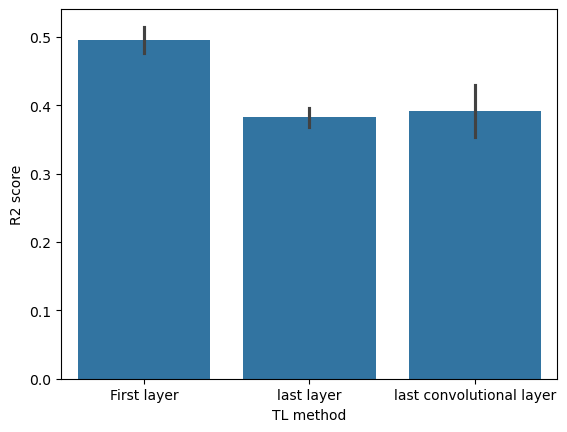

In [44]:
fig, ax = plt.subplots()
sns.barplot(data = df_all_pooled_TL, x = 'TL method', y='R2 score', ax=ax)

In [ ]:
for ind, score_dict in enumerate([results_combined_test_first]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, df_novar_full = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_full['region'] = 'all combined'
df_novar_pooled = pd.concat([df_novar_full, df_novar_pooled])
df_novar_pooled['Model'] = 'WaveNet TL'
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_TL2.csv')

In [53]:
for ind, score_dict in enumerate([results_combined_test_KG]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, df_novar_full = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_full['region'] = 'all combined'
df_novar_pooled = pd.concat([df_novar_full, df_novar_pooled])
df_novar_pooled['Model'] = 'WaveNet TL'
df_novar_pooled['TL method'] = 'KG'
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_TLKG.csv')

In [15]:
for ind, score_dict in enumerate([results_combined_test_last]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, df_novar_full = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_full['region'] = 'all combined'
df_novar_pooled = pd.concat([df_novar_full, df_novar_pooled])
df_novar_pooled['Model'] = 'WaveNet TL'
df_novar_pooled['TL method'] = 'last layer'
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_TL_last.csv')

In [16]:
df_novar_pooled

,Variety,R2 score,region,Model,TL method
0,combined,0.141897,all combined,WaveNet TL,last layer
0,combined,0.448704,semiarid low,WaveNet TL,last layer
1,combined,-0.089271,arid high,WaveNet TL,last layer
2,combined,0.115348,humid low,WaveNet TL,last layer
3,combined,0.135334,subhumid low,WaveNet TL,last layer
4,combined,-0.664594,humid high,WaveNet TL,last layer


In [17]:
for ind, score_dict in enumerate([results_combined_test_lastconv]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, df_novar_full = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_full['region'] = 'all combined'
df_novar_pooled = pd.concat([df_novar_full, df_novar_pooled])
df_novar_pooled['Model'] = 'WaveNet TL'
df_novar_pooled['TL method'] = 'last convolution'
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_TL_last_conv.csv')

In [18]:
df_novar_pooled

,Variety,R2 score,region,Model,TL method
0,combined,0.185980,all combined,WaveNet TL,last convolution
0,combined,0.409664,semiarid low,WaveNet TL,last convolution
1,combined,-0.076432,arid high,WaveNet TL,last convolution
2,combined,0.121617,humid low,WaveNet TL,last convolution
3,combined,0.084905,subhumid low,WaveNet TL,last convolution
4,combined,-0.044643,humid high,WaveNet TL,last convolution


In [22]:
for ind, score_dict in enumerate([results_combined_test_lwave]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, df_novar_full = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_full['region'] = 'all combined'
df_novar_pooled = pd.concat([df_novar_full, df_novar_pooled])
df_novar_pooled['Model'] = 'WaveNet TL'
df_novar_pooled['TL method'] = 'last wave'
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_TL_last_wave.csv')

In [23]:
df_novar_pooled

,Variety,R2 score,region,Model,TL method
0,combined,0.178561,all combined,WaveNet TL,last wave
0,combined,0.399608,semiarid low,WaveNet TL,last wave
1,combined,-0.078167,arid high,WaveNet TL,last wave
2,combined,0.097792,humid low,WaveNet TL,last wave
3,combined,0.090831,subhumid low,WaveNet TL,last wave
4,combined,-0.021343,humid high,WaveNet TL,last wave


In [20]:
for ind, score_dict in enumerate([results_combined_test_fwave]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, df_novar_full = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_full['region'] = 'all combined'
df_novar_pooled = pd.concat([df_novar_full, df_novar_pooled])
df_novar_pooled['Model'] = 'WaveNet TL'
df_novar_pooled['TL method'] = 'first wave'
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_TL_first_wave.csv')

In [21]:
df_novar_pooled

,Variety,R2 score,region,Model,TL method
0,combined,0.324890,all combined,WaveNet TL,first wave
0,combined,0.541776,semiarid low,WaveNet TL,first wave
1,combined,-0.020563,arid high,WaveNet TL,first wave
2,combined,0.188703,humid low,WaveNet TL,first wave
3,combined,0.131420,subhumid low,WaveNet TL,first wave
4,combined,0.075432,humid high,WaveNet TL,first wave


In [54]:
df_novar_pooled_first = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_TL2.csv')
df_novar_pooled_first['TL method'] = 'first layer'
df_novar_full = pd.concat([df_novar_pooled, df_novar_pooled_first])

In [55]:
df_novar_full

,Variety,R2 score,region,Model,TL method,Unnamed: 0
0,combined,0.370664,all combined,WaveNet TL,KG,NaN
0,combined,0.647313,semiarid low,WaveNet TL,KG,NaN
1,combined,-0.085107,arid high,WaveNet TL,KG,NaN
2,combined,-0.168669,humid low,WaveNet TL,KG,NaN
3,combined,0.377749,subhumid low,WaveNet TL,KG,NaN
4,combined,-0.552752,humid high,WaveNet TL,KG,NaN
0,combined,0.381362,all combined,WaveNet TL,first layer,0.0
1,combined,0.655353,semiarid low,WaveNet TL,first layer,0.0
2,combined,-0.005988,arid high,WaveNet TL,first layer,1.0
3,combined,-0.092806,humid low,WaveNet TL,first layer,2.0


In [19]:
df_noreg, df_noreg_pooled, ___ = make_df_from_score_dict(no_regions_test_first)
df_noreg_pooled['Variety'] = ['Early', 'Late']
df_noreg_pooled['Model'] = 'WaveNet TL'
df_noreg_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_regions_pooled_score_TL2.csv')

In [32]:
df_noreg_pooled['Variety'] = ['Early', 'Late']
df_noreg_pooled

,R2 score,Variety
0,0.545487,Early
1,0.519386,Late


In [33]:
df_novar_pooled

,R2 score,Variety,region
0,0.648866,combined,arid low
1,-0.108698,combined,arid high
2,0.445226,combined,humid low
3,0.116789,combined,humid high


In [52]:
df_novar_pooled

,R2 score,Variety,region
0,0.582781,combined,arid low
1,0.388195,combined,city
2,0.084034,combined,high
3,0.410809,combined,humid low


In [32]:
results_early_indomain = K_fold_transfer_regions(early_ds_dict, transfer_method='in domain', 
                                                 GDD_init = None, index_cols = ['Stations_id', 'year'])
results_late_indomain = K_fold_transfer_regions(late_ds_dict, transfer_method='in domain', 
                                                GDD_init = None, index_cols = ['Stations_id', 'year'])

Fold 1
120 torch.Size([25, 10, 163]) torch.Size([95, 10, 163])
0 9072.2841796875 9063.48046875
10 9072.2841796875 9063.48046875
20 9072.283203125 9063.4765625
30 9072.16015625 9063.2861328125
40 9050.1552734375 9023.130859375
50 1753.753173828125 2723.605712890625
60 1911.446044921875 1455.75927734375
70 1154.5855712890625 1237.21142578125
80 600.1605834960938 550.4257202148438
90 142.9539031982422 154.22409057617188
100 82.46056365966797 112.87832641601562
110 79.28739929199219 109.23445129394531
120 74.19752502441406 99.75254821777344
130 68.44441986083984 91.00102233886719
140 62.4751091003418 81.62598419189453
150 56.555023193359375 72.72119903564453
160 51.62495803833008 64.8559341430664
170 48.1573600769043 60.52021408081055
180 45.44129943847656 55.1794548034668
190 41.55121994018555 47.973140716552734
200 36.739601135253906 39.912052154541016
210 33.5536003112793 34.719261169433594
220 31.83933448791504 32.40492248535156
230 30.582735061645508 31.530250549316406
240 29.99221611

In [37]:
df = pd.DataFrame()
for ind, score_dict in enumerate([results_early_indomain, results_late_indomain]):
    variety = ['early', 'late'][ind]
    TL_method = ['first', 'first'][ind]
    df, df_pooled, df_full_model = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df['region'] = score_dict['regions']
    df_pooled['region'] = score_dict['regions']
    df_full_model['region'] = 'all combined'
    df = pd.concat((df, df_full_model))
    df_pooled = pd.concat((df_pooled, df_full_model))
    if ind == 0:
        df_full = df
        df_pooled_full = df_pooled
    else:
        df_full = pd.concat([df_full, df])
        df_pooled_full = pd.concat([df_pooled_full, df_pooled])
    
#df_full = df_full.drop(4)
#df_pooled_full = df_pooled_full.drop(4)

In [38]:
df_pooled_full

,R2 score,Variety,region
0,0.702886,early,semiarid low
1,-0.149496,early,arid high
2,-2.120817,early,humid low
3,-0.051448,early,subhumid low
4,-0.277398,early,humid high
0,0.343130,early,all combined
0,0.680976,late,semiarid low
1,0.001254,late,arid high
2,-0.395895,late,humid low
3,0.345022,late,subhumid low


In [39]:
df_pooled_full['Model'] = 'WaveNet in domain'
df_pooled_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_indomain_new_split.csv')

In [34]:
df_pooled_full

,R2 score,Variety,region
0,0.636790,early,semiarid low
1,-0.447836,early,arid high
2,-0.299039,early,humid low
3,0.003807,early,subhumid low
4,-0.699836,early,humid high
0,-0.047006,early,all combined
0,0.503182,late,semiarid low
1,-0.296993,late,arid high
2,-1.128901,late,subhumid low
3,-0.133040,late,humid high


In [35]:
df_pooled_full['Model'] = 'WaveNet in domain'
df_pooled_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_indomain_new_split.csv')

In [22]:
def skill_score_all_reg(score_dict):
    SSE_all_reg = np.array(score_dict['SSEs'])
    obsvars_all_reg = np.nan_to_num(np.array(score_dict['observed variances']))
    length_all_reg = np.array(score_dict['fold lengths'])
    MSE_all_reg = SSE_all_reg.sum(axis=0)/length_all_reg.sum(axis = 0)
    R2_all_reg = 1 - (SSE_all_reg.sum(axis=0)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=0))
    R2_all_reg_split = 1 - (SSE_all_reg/((length_all_reg - 1)*obsvars_all_reg))
    #R2_pooled = 1 - (SSE_all_reg.sum(axis=1)/((length_all_reg - 1)*obsvars_all_reg).sum(axis=1))
    R2_pooled = []
    for cf in score_dict['comparison_frames']:
        R2_pooled.append(r2_score(cf['observed'], cf['fitted']))
    R2_pooled = np.array(R2_pooled)
    return R2_all_reg, R2_all_reg_split, R2_pooled

def make_df_from_score_dict(score_dict, TL_method = 'NA', variety = 'NA'):
    R2s, R2s_split, R2s_pooled = skill_score_all_reg(score_dict)
    df = pd.DataFrame()
    df['R2 score'] = R2s_split.mean(axis=1)
    df_pooled = pd.DataFrame()
    df_pooled['R2 score'] = R2s_pooled
    df['Variety'] = variety
    df_pooled['Variety'] = variety
    df_full_model = pd.DataFrame()
    df_full_model['Variety'] = [variety]
    df_full_model['R2 score'] = [R2s.mean()]
    return df, df_pooled, df_full_model

In [43]:
df = pd.DataFrame()
for ind, score_dict in enumerate([results_late_first]):#results_early_first, 
    variety = ['late', 'late'][ind]
    TL_method = ['first', 'first'][ind]
    df, df_pooled, df_full_model = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df['region'] = score_dict['regions']
    df_pooled['region'] = score_dict['regions']
    df_full_model['region'] = 'all combined'
    df = pd.concat((df, df_full_model))
    df_pooled = pd.concat((df_pooled, df_full_model))
    if ind == 0:
        df_full = df
        df_pooled_full = df_pooled
    else:
        df_full = pd.concat([df_full, df])
        df_pooled_full = pd.concat([df_pooled_full, df_pooled])
    
#df_full = df_full.drop(4)
#df_pooled_full = df_pooled_full.drop(4)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20268\1566368759.py:7: RuntimeWarning: divide by zero encountered in divide
  R2_all_reg_split = 1 - (SSE_all_reg/((length_all_reg - 1)*obsvars_all_reg))


In [44]:
df_pooled_full

,R2 score,Variety,region
0,0.685473,late,semiarid low
1,-2.134110,late,arid high
2,-0.077107,late,humid low
3,0.017385,late,subhumid low
4,-0.014021,late,humid high
0,-1.204453,late,all combined


In [45]:
df_pooled_full2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_TL_new_split.csv')

In [46]:
df_pooled_full2 = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_TL_new_split.csv')
df_pooled_full['Model'] = 'WaveNet TL'
df_pooled_full2 = df_pooled_full2.loc[df_pooled_full2['Variety'] == 'early']
df_pooled_full2 = pd.concat([df_pooled_full, df_pooled_full2])

In [47]:
df_pooled_full2

,R2 score,Variety,region,Model,Unnamed: 0
0,0.685473,late,semiarid low,WaveNet TL,NaN
1,-2.134110,late,arid high,WaveNet TL,NaN
2,-0.077107,late,humid low,WaveNet TL,NaN
3,0.017385,late,subhumid low,WaveNet TL,NaN
4,-0.014021,late,humid high,WaveNet TL,NaN
0,-1.204453,late,all combined,WaveNet TL,NaN
0,0.598725,early,semiarid low,WaveNet TL,0.0
1,-0.975204,early,arid high,WaveNet TL,1.0
2,0.354687,early,humid low,WaveNet TL,2.0
3,0.401545,early,subhumid low,WaveNet TL,3.0


In [48]:
df_pooled_full['Model'] = 'WaveNet TL'
df_pooled_full2.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_TL_new_split.csv')

In [21]:
results_early_first = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer',
                                              index_cols = ['Stations_id', 'year'])
results_late_first = K_fold_transfer_regions(late_ds_dict, transfer_method='first_layer',
                                             index_cols = ['Stations_id', 'year'])

120 torch.Size([25, 10, 163]) torch.Size([95, 10, 163])
120 torch.Size([27, 10, 163]) torch.Size([93, 10, 163])
120 torch.Size([23, 10, 163]) torch.Size([97, 10, 163])
120 torch.Size([23, 10, 163]) torch.Size([97, 10, 163])
120 torch.Size([22, 10, 163]) torch.Size([98, 10, 163])
semiarid low [0.8355368375778198, 0.6670364141464233, 0.821462869644165, 0.7277457118034363, -0.6094682216644287]
59 torch.Size([13, 10, 163]) torch.Size([46, 10, 163])
59 torch.Size([13, 10, 163]) torch.Size([46, 10, 163])
59 torch.Size([10, 10, 163]) torch.Size([49, 10, 163])
59 torch.Size([11, 10, 163]) torch.Size([48, 10, 163])


c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


59 torch.Size([12, 10, 163]) torch.Size([47, 10, 163])
arid high [-0.9037653207778931, -0.33321499824523926, 0.25868314504623413, -0.8707485198974609, -0.05151176452636719]
26 torch.Size([7, 10, 163]) torch.Size([19, 10, 163])
26 torch.Size([5, 10, 163]) torch.Size([21, 10, 163])
26 torch.Size([5, 10, 163]) torch.Size([21, 10, 163])
26 torch.Size([4, 10, 163]) torch.Size([22, 10, 163])
26 torch.Size([5, 10, 163]) torch.Size([21, 10, 163])
humid low [0.1634615659713745, 0.7553516626358032, 0.3368421196937561, 0.1354466676712036, -0.22807013988494873]
67 torch.Size([14, 10, 163]) torch.Size([53, 10, 163])
67 torch.Size([11, 10, 163]) torch.Size([56, 10, 163])
67 torch.Size([14, 10, 163]) torch.Size([53, 10, 163])
67 torch.Size([13, 10, 163]) torch.Size([54, 10, 163])
67 torch.Size([15, 10, 163]) torch.Size([52, 10, 163])
subhumid low [0.36659467220306396, 0.4250319004058838, 0.7711626291275024, -0.5780346393585205, 0.5679405927658081]
45 torch.Size([10, 10, 163]) torch.Size([35, 10, 163]

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


17 torch.Size([2, 10, 163]) torch.Size([15, 10, 163])
humid low [-14.030303001403809, -1.3106060028076172, -0.5600000619888306, -24.500001907348633, 0.3199999928474426]
68 torch.Size([14, 10, 163]) torch.Size([54, 10, 163])
68 torch.Size([17, 10, 163]) torch.Size([51, 10, 163])
68 torch.Size([12, 10, 163]) torch.Size([56, 10, 163])
68 torch.Size([11, 10, 163]) torch.Size([57, 10, 163])
68 torch.Size([14, 10, 163]) torch.Size([54, 10, 163])
subhumid low [0.4366617202758789, 0.3215346336364746, -0.6304346323013306, -0.00769960880279541, 0.41578352451324463]
46 torch.Size([12, 10, 163]) torch.Size([34, 10, 163])
46 torch.Size([7, 10, 163]) torch.Size([39, 10, 163])
46 torch.Size([9, 10, 163]) torch.Size([37, 10, 163])
46 torch.Size([10, 10, 163]) torch.Size([36, 10, 163])
46 torch.Size([8, 10, 163]) torch.Size([38, 10, 163])
humid high [0.2532689571380615, -1.228947401046753, -2.024193286895752, -2.789438009262085, -0.3871450424194336]


In [45]:
results_early_KG = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer',
                                              index_cols = ['Stations_id'])
results_late_KG = K_fold_transfer_regions(late_ds_dict, transfer_method='first_layer',
                                             index_cols = ['Stations_id'])

120 torch.Size([29, 8, 163]) torch.Size([91, 8, 163])
120 torch.Size([25, 8, 163]) torch.Size([95, 8, 163])
120 torch.Size([27, 8, 163]) torch.Size([93, 8, 163])
120 torch.Size([19, 8, 163]) torch.Size([101, 8, 163])
120 torch.Size([20, 8, 163]) torch.Size([100, 8, 163])
semiarid low [-0.39970195293426514, 0.4498922824859619, 0.6198835372924805, 0.8640702962875366, 0.28348463773727417]
66 torch.Size([31, 8, 163]) torch.Size([35, 8, 163])
66 torch.Size([5, 8, 163]) torch.Size([61, 8, 163])
66 torch.Size([9, 8, 163]) torch.Size([57, 8, 163])
66 torch.Size([14, 8, 163]) torch.Size([52, 8, 163])
66 torch.Size([7, 8, 163]) torch.Size([59, 8, 163])
arid high [-0.32214653491973877, -0.2314814329147339, -14.490384101867676, -2.0704312324523926, -0.6519174575805664]
26 torch.Size([4, 8, 163]) torch.Size([22, 8, 163])
26 torch.Size([4, 8, 163]) torch.Size([22, 8, 163])


KeyboardInterrupt: 

In [42]:
results_late_first['regions']

['semiarid low', 'arid high', 'subhumid low', 'humid high']

In [40]:
results_early_first['fold lengths']

[[29, 25, 27, 19, 20],
 [31, 5, 9, 14, 7],
 [4, 4, 10, 3, 5],
 [7, 14, 16, 10, 21],
 [6, 17, 12, 11, 3]]

In [ ]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}
no_regions_test_first = K_fold_transfer_regions(no_regions_dict, transfer_method='first_layer')
results_combined_test_first = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='first_layer')

arid low [0.6597704887390137, 0.5774587392807007, 0.677506685256958, 0.6722699403762817, 0.43378692865371704]
city [-1.273137092590332, -0.2939565181732178, 0.32977408170700073, 0.5671672224998474, 0.11263060569763184]
high [-0.26778507232666016, -0.510509729385376, 0.3872688412666321, -0.7554770708084106, 0.5567138195037842]
humid low [0.28707629442214966, 0.39179491996765137, 0.49279874563217163, 0.11055564880371094, -0.20911407470703125]


In [ ]:
df = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\NEW_error_df_WaveNet.csv')
df = pd.concat([df, pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\NEW_error_df_GDD.csv')])
df = pd.concat([df, pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\NEW_error_df_NN.csv')])

In [ ]:
results_combined_test_KG = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='KG')

arid low [0.5712378025054932, 0.5301657319068909, 0.47314339876174927, 0.6457638144493103, 0.43831098079681396]
city [-1.7144525051116943, -0.42280375957489014, 0.22505134344100952, 0.6890102624893188, 0.1598801612854004]
high [-0.03217899799346924, -0.46213293075561523, 0.4209548234939575, -0.8959364891052246, 0.40191543102264404]
humid low [0.25, 0.3023722767829895, 0.3436219096183777, -0.06570041179656982, 0.011920928955078125]


In [ ]:
results_combined_test_last = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='last_conv')

arid low [0.43232643604278564, 0.5870893001556396, 0.5140600800514221, 0.4916588068008423, 0.21311265230178833]
city [-2.0385663509368896, -1.5851712226867676, -0.4085214138031006, -0.38668930530548096, -1.42240309715271]


KeyboardInterrupt: 

In [22]:
df = pd.DataFrame()
for ind, score_dict in enumerate([results_early_first, results_late_first]):
    variety = ['early', 'late'][ind]
    TL_method = ['first', 'first'][ind]
    df, df_pooled, df_full_model = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df['region'] = score_dict['regions']
    df_pooled['region'] = score_dict['regions']
    df_full_model['region'] = 'all combined'
    df = pd.concat((df, df_full_model))
    df_pooled = pd.concat((df_pooled, df_full_model))
    if ind == 0:
        df_full = df
        df_pooled_full = df_pooled
    else:
        df_full = pd.concat([df_full, df])
        df_pooled_full = pd.concat([df_pooled_full, df_pooled])
    
#df_full = df_full.drop(4)
#df_pooled_full = df_pooled_full.drop(4)

In [23]:
df_pooled_full['Model'] = 'WaveNet TL'
df_pooled_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_TL_small_new_split.csv')

In [35]:
df_pooled_full

,R2 score,Variety,region
0,0.632429,early,semiarid low
1,-0.031097,early,arid high
2,0.421982,early,humid low
3,0.414880,early,subhumid low
4,0.060919,early,humid high
0,0.426391,early,all combined
0,0.727585,late,semiarid low
1,-0.078980,late,arid high
2,-0.601539,late,humid low
3,0.297333,late,subhumid low


In [ ]:
df_pooled_full

,R2 score,Variety,region
0,0.642252,early,arid low
1,-0.142327,early,arid high
2,0.537099,early,humid low
3,-0.118305,early,humid high
0,0.478152,early,all combined
0,0.752701,late,arid low
1,-0.266914,late,arid high
2,0.168649,late,humid low
3,-0.024499,late,humid high
0,0.444983,late,all combined


In [ ]:
#df_noreg, df_noreg_pooled, ___ = make_df_from_score_dict(no_regions_test_first)
for ind, score_dict in enumerate([results_combined_test_first]):# results_dict_late]):
    variety = ['combined'][ind]
    TL_method = ['first', 'first'][ind]
    df_novar, df_novar_pooled, ____ = make_df_from_score_dict(score_dict, TL_method=TL_method, variety=variety)
    df_novar['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])
    df_novar_pooled['region'] = score_dict['regions']#np.array(['arid low', 'city', 'high', 'humid low'])

In [22]:
df_pooled_full

,R2 score,Variety,region
0,0.621301,early,arid low
1,0.510158,early,city
2,0.258215,early,high
3,0.475835,early,humid low
0,0.476444,early,all combined
0,0.627340,late,arid low
1,0.010447,late,city
2,-0.388020,late,high
3,0.326343,late,humid low
0,0.311563,late,all combined


In [ ]:
df_novar

,R2 score,Variety,region
0,0.595301,combined,arid low
1,-0.111341,combined,city
2,-0.020911,combined,high
3,0.240484,combined,humid low


In [ ]:
df_novar_pooled

,R2 score,Variety,region
0,0.553225,combined,arid low
1,0.105751,combined,city
2,0.256981,combined,high
3,0.393867,combined,humid low


In [ ]:
df_novar_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_pooled_score_TL_new_vpd.csv')

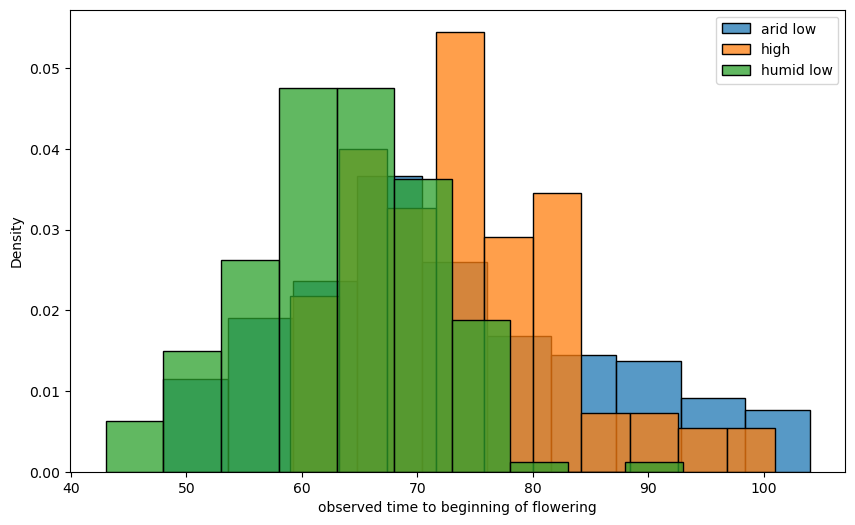

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
for region in combined_variety_tests_dict.keys():
    if region == 'cool' or region == 'city':
        continue
    sns.histplot(combined_variety_tests_dict[region]['observed time to beginning of flowering'], bins=10, stat = 'density', label = region, ax=ax)
ax.legend()

In [ ]:
df_noreg_pooled

,R2 score,Variety
0,0.528889,NA
1,0.515171,NA


In [ ]:
for ds in early_ds_dict.values():
    #print(ds['Referenzjahr'].values)
    X_tensor, y_tensor = ML_tensor_from_ds(ds)
    print(X_tensor.shape, y_tensor.shape)

83
83
torch.Size([83, 8, 163]) torch.Size([83, 163])
86
86
torch.Size([86, 8, 163]) torch.Size([86, 163])
55
55
torch.Size([55, 8, 163]) torch.Size([55, 163])


In [31]:
lr = 0.0001
#lr = 0.01
#save_name = save_name = 'CCNN_KG_DE_pre_2022_for_TL_huge_more_epochs'#'CCNN_KG_DE_pre_2022_for_TL2'
#save_name = 'CCNN_KG_DE_pre_2022_for_TL_no_vpd'
#transfer_method= 'KG'#'first_layer'#
#transfer_method= 'last_layer'#
epochs = 500
bs = 500
n_channels = 5#4
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 2
normalise_at_end = False#True
num_layers = 1
output_dim = 1 
KG = True
MMD = False
regression = False
KG_vpd = False
CNN = True
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
#get data for specific region
#ds_highlands = late_ds_dict['high']#last_tests_dict['highlands full']
#convert to pytorch format
#X_tensor, y_tensor = ML_tensor_from_ds(ds_highlands)
#train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
#run K-fold cross validation
criterion = problist_square_loss()
comparison_frame_full, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_crossval(5, late_ds_dict['arid high'], Causal_CNN_Classifier_KG,#
                                                                                                        epochs, bs, model_args, 
                                                                                                        lr = lr, n_channels=5,
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                        custom_loss=problist_square_loss, DTF = False, 
                                                                                                        verbose=True,GDD_init='calculate',#None,#
                                                                                                        index_cols = ['Stations_id'])#

Fold 1
56 torch.Size([15, 8, 163]) torch.Size([41, 8, 163])
Optimization terminated successfully.
         Current function value: 5.695316
         Iterations: 66
         Function evaluations: 163
[ 0.5  8.  23.  39. ] [ 0.27968549  8.66438231 22.82420974 39.300801  ] [ 0.22031451 -0.66438231  0.17579026 -0.300801  ]
RMSE at opt on test set:  4.959091912093644
R^2: -1.1007339913945842
[ 0.27968549  8.66438231 22.82420974 39.300801  ]
0 18.284555435180664 10.644559860229492
10 16.763940811157227 12.828715324401855
20 16.545246124267578 12.505436897277832
30 16.281333923339844 12.474833488464355
40 16.011167526245117 12.490570068359375
50 15.751500129699707 12.345112800598145
60 15.514805793762207 12.468779563903809
70 15.293671607971191 12.245681762695312
80 15.08485221862793 12.414336204528809
90 14.884651184082031 12.198369026184082
100 14.69182300567627 12.36241340637207
110 14.505474090576172 12.138836860656738
120 14.32490348815918 12.316057205200195
130 14.149698257446289 12.089

In [32]:
R2s

[-1.2779040336608887,
 0.10251396894454956,
 -10.305590629577637,
 0.3717948794364929,
 -0.6890668869018555]

In [104]:
err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'WaveNet', 'DE', '5-fold year CV')
err_df

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,WaveNet,DE,5-fold year CV,-0.122978,-1.225714,71.613135,7.715481,7.53636,0.409461,-12.2,-6.45,-1.4,4.45,8.8


In [118]:
R2s

[-1.1668806076049805,
 0.25974375009536743,
 0.20770293474197388,
 -0.4778714179992676,
 0.07407408952713013]

In [119]:
r2_score(comparison_frame_full['observed'], comparison_frame_full['fitted'])

-0.3458523750305176

In [99]:
err_df

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,WaveNet,DE,5-fold year CV,0.368451,0.243295,42.048313,8.737896,6.456324,0.620351,-46.6,-5.0,0.0,5.2,45.0


In [100]:
R2s

[0.36611878871917725,
 0.3680344223976135,
 0.38117194175720215,
 0.3373916745185852,
 0.3895382881164551]

In [96]:
R2s

[0.32842689752578735,
 0.2677253484725952,
 0.3216697573661804,
 0.33662813901901245,
 0.36419981718063354]

In [77]:
r2_score(comparison_frame_full['observed'], comparison_frame_full['fitted'])

0.6254413723945618

In [46]:
r2_score(comparison_frame_full['observed'], comparison_frame_full['fitted'])

-0.07776749134063721

In [ ]:
lr = 0.0001
epochs = 200
bs = 500
n_channels = 5#4
hidden_dim = 4
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_crossval(5, combined_variety_tests_dict['arid high'], Causal_CNN_Classifier_KG, 
                                                                                                        epochs, bs, model_args, 
                                                                                                        lr = lr, n_channels=5,
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                        custom_loss=problist_square_loss, DTF = False, verbose=True,GDD_init='calculate')

In [24]:
lr = 0.001
save_name = 'CCNN_KG_DE_pre_2022_for_TL'#_huge'#'CCNN_KG_DE_pre_2022_for_TL2'
#save_name = 'CCNN_KG_DE_pre_2022_for_TL_no_vpd'
transfer_method= 'KG'#'first_layer'#
#transfer_method= 'last_wave'#
transfer_method= 'first_layer'#
epochs = 200
bs = 500
n_channels = 5#4
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
normalise_at_end = False#True
num_layers = 3
output_dim = 1 
KG = True
MMD = False
regression = False
KG_vpd = False
CNN = True
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
#get data for specific region
#ds_highlands = late_ds_dict['high']#last_tests_dict['highlands full']
#convert to pytorch format
#X_tensor, y_tensor = ML_tensor_from_ds(ds_highlands)
#train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
#run K-fold cross validation
criterion = problist_square_loss()
comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, late_ds_dict['arid high'], Causal_CNN_Classifier_KG, 
                                                                                                        save_name, epochs, bs, model_args, savename_prefix = 'WaveNet_TL_semiarid',
                                                                                                        transfer_method=transfer_method, lr = lr, 
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                        custom_loss=criterion, DTF = False, verbose=True,
                                                                                                        index_cols = ['Stations_id'])

50 torch.Size([17, 10, 163]) torch.Size([33, 10, 163])
0 41.48320007324219 12.532376289367676
50 17.647029876708984 18.240324020385742
100 16.344205856323242 16.441177368164062
150 15.370124816894531 15.135481834411621
50 torch.Size([11, 10, 163]) torch.Size([39, 10, 163])
0 37.52558898925781 9.400490760803223
50 12.955446243286133 9.22029972076416
100 12.71452522277832 9.221053123474121
150 12.729243278503418 9.826593399047852
50 torch.Size([5, 10, 163]) torch.Size([45, 10, 163])
0 32.76628875732422 7.336966037750244
50 12.417268753051758 10.64531135559082
100 12.310296058654785 11.522804260253906
150 12.570282936096191 8.999723434448242
50 torch.Size([11, 10, 163]) torch.Size([39, 10, 163])
0 28.229063034057617 10.217602729797363
50 12.779298782348633 10.691449165344238
100 12.317183494567871 13.3495512008667
150 12.192386627197266 10.628311157226562
50 torch.Size([6, 10, 163]) torch.Size([44, 10, 163])
0 24.460798263549805 34.06576919555664
50 10.212851524353027 30.73813819885254
10

In [58]:
comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, late_ds_dict['arid high'], Causal_CNN_Classifier_KG, 
                                                                                                            save_name, epochs, bs, model_args, 
                                                                                                            transfer_method=transfer_method, lr = lr, 
                                                                                                            loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                            custom_loss=criterion, DTF = False, verbose=True,
                                                                                                            index_cols = ['Stations_id'])

50 torch.Size([17, 10, 163]) torch.Size([33, 10, 163])
0 41.48320007324219 12.532377243041992
50 17.65290069580078 18.2528133392334
50 torch.Size([11, 10, 163]) torch.Size([39, 10, 163])
0 37.52558517456055 9.400490760803223
50 13.171089172363281 8.709632873535156
50 torch.Size([5, 10, 163]) torch.Size([45, 10, 163])
0 32.76628875732422 7.336967468261719
50 13.235791206359863 8.747385025024414
50 torch.Size([11, 10, 163]) torch.Size([39, 10, 163])
0 28.229061126708984 10.21760082244873
50 12.780136108398438 10.691659927368164
50 torch.Size([6, 10, 163]) torch.Size([44, 10, 163])
0 24.460798263549805 34.06576919555664
50 10.212813377380371 30.738134384155273


In [36]:
16171/1000000

0.016171

In [105]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])#combined_variety_tests_dict['humid high'][['Management']].value_counts()#[['Management']].pivot_table('Management')

-0.2210613489151001

In [ ]:

r2_score(comparison_frame['observed'], comparison_frame['fitted'])

SyntaxError: invalid syntax (2264257760.py, line 2)

In [106]:
R2s

[-1.069685459136963,
 -2.4290125370025635,
 -11.884614944458008,
 -1.2575757503509521,
 0.1979573369026184]

In [20]:
R2s

[-0.7154150009155273,
 0.3696076273918152,
 0.2981278896331787,
 0.7312450408935547,
 -0.6898411512374878]

In [22]:
comparison_frame

,fitted,observed,Error
0,71.0,75.0,4.0
1,70.0,75.0,5.0
2,71.0,73.0,2.0
3,70.0,73.0,3.0
4,72.0,70.0,-2.0
5,72.0,79.0,7.0
6,72.0,77.0,5.0
7,72.0,81.0,9.0
8,69.0,77.0,8.0
9,75.0,71.0,-4.0


In [ ]:
#r2_score(comparison_frame['observed'], comparison_frame['fitted'])#combined_variety_tests_dict['humid high'][['Management']].value_counts()#[['Management']].pivot_table('Management')

-0.005205512046813965

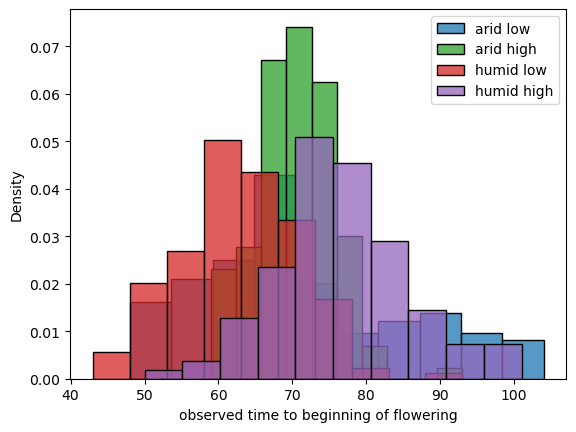

In [48]:
fig, ax=plt.subplots()
for i, df in enumerate(combined_variety_tests_dict.values()):
    if i >=5:
        continue
    sns.histplot(df['observed time to beginning of flowering'], bins=10, stat = 'density', ax=ax, label = list(combined_variety_tests_dict.keys())[i])
ax.legend()

In [33]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])

-0.12825286388397217

131
131
0 151.74657953702487 121.74935913085938
5 99.77452512887808 56.48715591430664
10 48.48325538635254 29.194202423095703
15 28.16449708205003 24.360671997070312
20 23.585933171785793 24.883358001708984
25 23.286226162543663 26.12717056274414
30 23.184525049649753 26.573314666748047
35 22.931029576521652 26.54305648803711
40 22.770640006432167 26.573808670043945
45 22.75050372343797 26.773157119750977
50 22.775408524733322 26.979446411132812
55 22.79882475046011 27.110042572021484
60 22.808528129871075 27.16740608215332
65 22.80759334564209 27.178476333618164
70 22.802307715782753 27.167871475219727
75 22.796489018660324 27.15083885192871
80 22.79124747789823 27.133771896362305
85 22.786448331979607 27.11782455444336
90 22.781733366159294 27.10234832763672
95 22.77695211997399 27.086732864379883


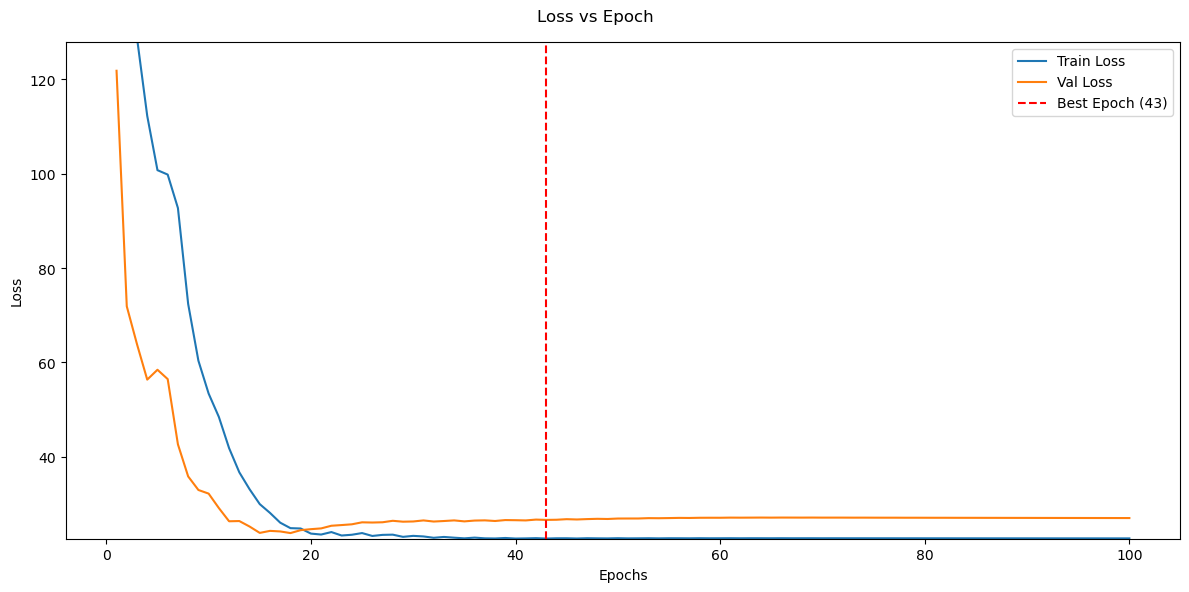

In [ ]:
bs=100
n_channels = 5
transfer_method = 'first_layer'
X_tensor, y_tensor = ML_tensor_from_ds(last_tests_dict['highlands full'])#early_ds_dict['arid low'])
train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
train_dl, val_dl = train_test_dl_from_tensors(X_tensor, y_tensor, bs = bs, n_channels = n_channels, train_proportion=0.8)
#train_dl, val_dl = train_test_dl_by_year(temp_NDVI_series_DE, NDVI_labels_DE, test_years = [2022, 2023, 2024], year_column = -2, bs = bs, n_channels = 8, train_proportion=0.8)
save_name_mother = 'CCNN_KG_DE_pre_2022_for_TL2'
epochs = 1000
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
normalise_at_end = False#True
num_layers = 3
output_dim = 1 
KG = True
MMD = False
regression = False
KG_vpd = False
CNN = True
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
model= Causal_CNN_Classifier_KG(*model_args)
trained_model = load_model(save_name_mother, model)
criterion = problist_square_loss()
if transfer_method == 'KG':
    lr = 0.01
    epochs = 500
else:
    lr = 0.05
    epochs = 500
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay = 0.001)
ft_params = get_ft_params(trained_model, transfer_method=transfer_method)
for param in model.parameters():
    param.requires_grad = False
for param in ft_params:
    param.requires_grad = True
fit(epochs, trained_model, criterion, optimizer, train_dl, val_dl, save_name = save_name_mother + '_transferred', CNN = CNN, bce=bce, MMD=MMD)

In [ ]:
lr = 0.05
save_name = 'CCNN_KG_DE_pre_2022_for_TL2'
transfer_method='first_layer'
epochs = 100
bs = 500
n_channels = 5
input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
normalise_at_end = False#True
num_layers = 3
output_dim = 1 
KG = True
MMD = False
regression = False
KG_vpd = False
CNN = True
bce = True
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG, MMD, None, regression, KG_vpd, normalise_at_end, 8, 22, 39)
#get data for specific region
ds_highlands = late_ds_dict['high']#last_tests_dict['highlands full']
#convert to pytorch format
X_tensor, y_tensor = ML_tensor_from_ds(ds_highlands)
train_ds, val_ds = train_test_ds_from_tensors(X_tensor, y_tensor, train_proportion=1)
#run K-fold cross validation
criterion = problist_square_loss()
comparison_frame, loss_values, R2s, Biases, Variances, RMSEs, SSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, lengths, obsvars = K_fold_transfer(5, train_ds, Causal_CNN_Classifier_KG, 
                                                                                                        save_name, epochs, bs, model_args, 
                                                                                                        transfer_method=transfer_method, lr = lr, 
                                                                                                        loss = 'MSE', CNN=CNN, bce=bce, 
                                                                                                        custom_loss=criterion, DTF = False)
print('highlands full', R2s)
#Store sum of squared errors, variance of obs and length of folds for evaluation

62
62
highlands full [0.4252772927284241, -0.0708475112915039, -4.194500923156738, 0.46727466583251953, -0.2838233709335327]


In [ ]:
no_regions_dict = {'early full': ds_SSA_early,
                   'late full': ds_SSA_late}

In [ ]:
combined_variety_tests_dict = {key: pd.concat((early_ds_dict[key], late_ds_dict[key])) for key in early_ds_dict.keys()}

In [ ]:
df, df_pooled = make_df_from_score_dict(no_regions_test_first)
df#_pooled

,R2 score,Variety
0,0.613534,NA
1,0.595885,NA


In [ ]:
#no_regions_test_first = K_fold_transfer_regions(no_regions_dict, transfer_method='first_layer')
#results_combined_test_first = K_fold_transfer_regions(combined_variety_tests_dict, transfer_method='first_layer')

In [ ]:
df_pooled.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\combined_varieties_score_TL_new_eval.csv')

In [ ]:
#results_early_first_hps = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer')
#results_late_first_hps = K_fold_transfer_regions(late_ds_dict, transfer_method='first_layer')

In [ ]:
#results_early_KG = K_fold_transfer_regions(early_ds_dict)
#results_late_KG = K_fold_transfer_regions(late_ds_dict)
#results_early_first = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer')
#results_late_first = K_fold_transfer_regions(late_ds_dict, transfer_method='first_layer')
#results_early_last_conv = K_fold_transfer_regions(early_ds_dict, transfer_method='last_conv')
#results_late_last_conv = K_fold_transfer_regions(late_ds_dict, transfer_method='last_conv')
#results_early_last = K_fold_transfer_regions(early_ds_dict, transfer_method='last_layer')
#results_late_last = K_fold_transfer_regions(late_ds_dict,transfer_method='last_layer')

In [ ]:
results_early_first_new_split = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer')

125
125
arid low [0.6480962038040161, 0.7346668243408203, 0.7110372185707092, 0.8603478670120239, 0.14413630962371826]
53
53
city [0.7665618658065796, 0.4158684015274048, 0.6652498841285706, 0.6279577016830444, 0.6543921232223511]
69
69
high [0.5146205425262451, 0.338775098323822, -0.3686026334762573, 0.49393773078918457, 0.386594295501709]
81
81
humid low [0.6747186183929443, 0.533537745475769, 0.4760345220565796, 0.5647058486938477, 0.07605141401290894]
10
10
cool [-5.559999942779541, 0.09375, -8.847222328186035, -0.8877551555633545, -0.039999961853027344]


In [ ]:
results_late_first_new_split = K_fold_transfer_regions(late_ds_dict, transfer_method='first_layer')
results_early_first_new_split = K_fold_transfer_regions(early_ds_dict, transfer_method='first_layer')

109
109
arid low [0.8412555456161499, 0.6064133644104004, 0.6970483064651489, 0.8457937240600586, 0.7301465272903442]
44
44
city [0.4725840091705322, 0.663636326789856, 0.08646613359451294, -0.2626521587371826, -0.5010197162628174]
62
62
high [-0.16164004802703857, -2.002199411392212, 0.4243869185447693, 0.42406612634658813, -0.5557644367218018]
79
79
humid low [0.25946539640426636, 0.4977777600288391, 0.47463494539260864, 0.6470211744308472, 0.6789536476135254]


In [ ]:
score_dict = results_early_first_new_split
variety = 'early'
TL_method = 'first'
R2s = skill_score_all_reg(score_dict)
scores_by_set_method = pd.DataFrame({'Variety': [variety],
                            'TL method': [TL_method],
                            'R2 Fold 1': [R2s[0]],
                            'R2 Fold 2': [R2s[1]],
                            'R2 Fold 3': [R2s[2]],
                            'R2 Fold 4': [R2s[3]],
                            'R2 Fold 5': [R2s[4]]})

TypeError: unhashable type: 'slice'

In [ ]:
for method_ind in range(4):
    score_dict = [results_early_KG, results_late_KG, results_early_first, results_late_first][method_ind]
    variety = ['early', 'late', 'early', 'late'][method_ind]
    TL_method = ['KG', 'KG', 'first', 'first'][method_ind]
    R2s, R2s_split = skill_score_all_reg(score_dict)
    scores_by_set_method = pd.DataFrame({'Variety': [variety],
                              'TL method': [TL_method],
                              'R2 Fold 1': [R2s[0]],
                              'R2 Fold 2': [R2s[1]],
                              'R2 Fold 3': [R2s[2]],
                              'R2 Fold 4': [R2s[3]],
                              'R2 Fold 5': [R2s[4]]})
    if method_ind == 0:
        scores_full = scores_by_set_method
    else: scores_full = pd.concat((scores_full, scores_by_set_method),axis=0)

In [ ]:
R2s_split.mean(axis=1)

array([ 0.70757794, -0.99772919, -0.27989086,  0.54540997])

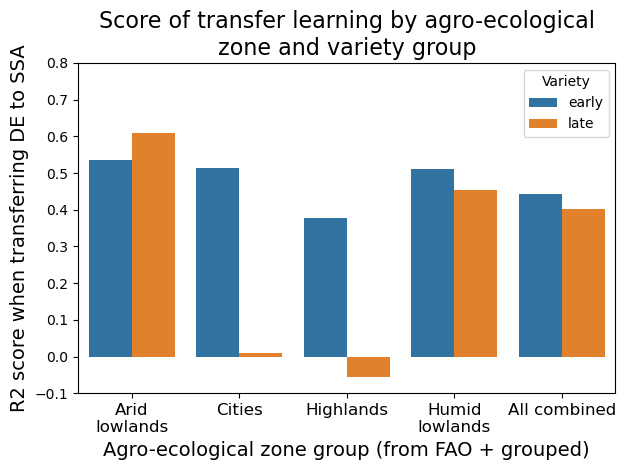

In [ ]:
font_size = 14
fig, ax = plt.subplots()
sns.barplot(data = df_pooled_full, hue = 'Variety', x = 'region', y='R2 score', ax=ax)
ax.set_xticks(range(5), ['Arid\nlowlands', 'Cities', 'Highlands', 'Humid\nlowlands', 'All combined'], fontsize =font_size - 2)
ax.set_ylabel('R2 score when transferring DE to SSA', fontsize =font_size)
ax.set_xlabel('Agro-ecological zone group (from FAO + grouped)', fontsize =font_size)
ax.set_title('Score of transfer learning by agro-ecological\nzone and variety group', fontsize = font_size +2)
ax.set_ylim((-0.1, 0.8))
fig.tight_layout()

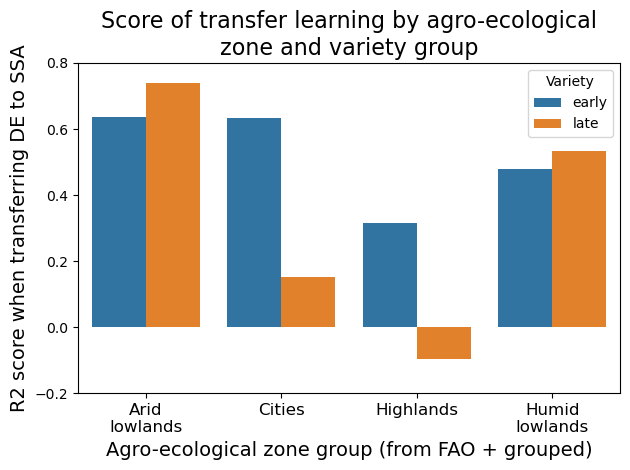

In [ ]:
font_size = 14
fig, ax = plt.subplots()
sns.barplot(data = df_pooled_full, hue = 'Variety', x = 'region', y='R2 score', ax=ax)
ax.set_xticks(range(4), ['Arid\nlowlands', 'Cities', 'Highlands', 'Humid\nlowlands'], fontsize =font_size - 2)
ax.set_ylabel('R2 score when transferring DE to SSA', fontsize =font_size)
ax.set_xlabel('Agro-ecological zone group (from FAO + grouped)', fontsize =font_size)
ax.set_title('Score of transfer learning by agro-ecological\nzone and variety group', fontsize = font_size +2)
ax.set_ylim((-0.2, 0.8))
fig.tight_layout()

In [ ]:
df_pooled_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_pooled_score_TL.csv')

In [ ]:
df_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\TL_tests\\split_varieties_score_TL.csv')

In [ ]:
score_dict = results_early_first
SSE_all_reg = np.array(score_dict['SSEs'])
obsvars_all_reg = np.array(score_dict['observed variances'])
length_all_reg = np.array(score_dict['fold lengths'])
MSE_all_reg = SSE_all_reg.sum(axis=0)/length_all_reg.sum(axis = 0)
R2_all_reg = 1 - (SSE_all_reg/((length_all_reg-1)*obsvars_all_reg))